# 1.0 An end-to-end classification problem (Training)



## 1.1 Dataset description

The notebooks focus on a borrower's **credit modeling problem**. The database was downloaded through a dataquest project and is available at link below. The data is from **Lending Club** and contains data from loans made in the period **2007 to 2011**. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. The **target variable**, or what we are wanting to predict, is whether or not, given a person's history, they will repay the loan.

You can download the data from the [Kaggle](https://www.kaggle.com/datasets/samaxtech/lending-club-20072011-data).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>

## 1.2 Install, load libraries

In [334]:
#!pip install imblearn

In [335]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [336]:
import os

In [337]:
from dotenv import load_dotenv
load_dotenv()

WANDB_API_KEY=os.environ.get('WANDB_API_KEY')
wandb.login(key=WANDB_API_KEY)

True

## 1.3 Holdout Configuration

In [338]:
# global variables

# ratio used to split train and test data
val_size = 0.2

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "y"

# name of the input artifact
artifact_input_name = "Bank-Marketing/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [339]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="Bank-Marketing",job_type="train")

logger.info("Downloading and reading train artifact")
artifact = run.use_artifact(artifact_input_name)
artifact_dir = artifact.download()
local_path = os.path.join(artifact_dir, "train.csv")
df_train = pd.read_csv(local_path)
logger.info("Reading train.csv")

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

08-05-2025 21:28:25 Downloading and reading train artifact
08-05-2025 21:28:27 Reading train.csv
08-05-2025 21:28:27 Spliting data into train/val


In [340]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

08-05-2025 21:28:27 x train: (25218, 20)
08-05-2025 21:28:27 y train: (25218,)
08-05-2025 21:28:27 x val: (6305, 20)
08-05-2025 21:28:27 y val: (6305,)


In [341]:
x_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25,admin,married,unknown,no,no,no,cellular,nov,thu,1,NaN,0,nonexistent,-3.4,92.649,-30.1,0.714,5017.5,0
19855,55,unemployed,married,basic 9y,no,yes,no,cellular,oct,tue,1,NaN,0,nonexistent,-3.4,92.431,-26.9,0.728,5017.5,0
19351,49,blue-collar,single,basic 6y,no,yes,no,telephone,may,wed,4,NaN,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0
7106,30,blue-collar,married,basic 9y,no,no,no,cellular,nov,wed,5,NaN,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0
24031,37,student,divorced,university degree,no,yes,yes,cellular,may,thu,2,NaN,0,nonexistent,-1.8,93.876,-40.0,0.699,5008.7,0


## 1.4 Data preparation

### 1.4.1 Outlier Removal

In [342]:
from sklearn.impute import SimpleImputer

# Separate numeric columns
numeric_columns = x_train.select_dtypes(include=['float64', 'int64']).columns

# Create the imputer for numeric columns
imputer = SimpleImputer(strategy='median')

# Fit and transform the numeric columns only
x_train[numeric_columns] = imputer.fit_transform(x_train[numeric_columns])
x_val[numeric_columns] = imputer.transform(x_val[numeric_columns])


In [343]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes('float64').copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

08-05-2025 21:28:29 Outlier Removal


In [344]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

08-05-2025 21:28:34 x_train shape [original]: (25218, 20)
08-05-2025 21:28:34 x_train shape [outlier removal]: (20069, 20)


In [345]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

In [346]:
x_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25.0,admin,married,unknown,no,no,no,cellular,nov,thu,1.0,6.0,0.0,nonexistent,-3.4,92.649,-30.1,0.714,5017.5,0.0
19855,55.0,unemployed,married,basic 9y,no,yes,no,cellular,oct,tue,1.0,6.0,0.0,nonexistent,-3.4,92.431,-26.9,0.728,5017.5,0.0
19351,49.0,blue-collar,single,basic 6y,no,yes,no,telephone,may,wed,4.0,6.0,0.0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0.0
7106,30.0,blue-collar,married,basic 9y,no,no,no,cellular,nov,wed,5.0,6.0,0.0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0.0
24031,37.0,student,divorced,university degree,no,yes,yes,cellular,may,thu,2.0,6.0,0.0,nonexistent,-1.8,93.876,-40.0,0.699,5008.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17441,49.0,technician,married,professional course,unknown,yes,no,telephone,jun,wed,13.0,6.0,0.0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0.0
9591,47.0,blue-collar,married,basic 4y,unknown,unknown,unknown,telephone,may,tue,2.0,6.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.0
20180,46.0,admin,single,university degree,no,yes,no,cellular,jul,thu,1.0,6.0,0.0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,0.0
17132,35.0,unemployed,married,university degree,no,no,no,telephone,jun,fri,2.0,6.0,0.0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0.0


### 1.4.2 Encoding Target Variable

In [347]:
y_train.head(10)

7234     yes
19855     no
19351     no
7106      no
24031    yes
6685      no
27059     no
26261    yes
14623     no
13723     no
Name: y, dtype: object

In [348]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

08-05-2025 21:28:36 Encoding Target Variable
08-05-2025 21:28:36 Classes [0, 1]: ['no' 'yes']


In [349]:
y_train

array([1, 0, 0, ..., 1, 0, 0])

In [350]:
y_val

array([0, 0, 0, ..., 0, 0, 0])

### 1.4.3 Using a full-pipeline

```
A reproducible pipeline is all you need
```

#### 1.4.3.1 Feature Extractor

In [351]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [352]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
7234,admin,married,unknown,no,no,no,cellular,nov,thu,nonexistent
19855,unemployed,married,basic 9y,no,yes,no,cellular,oct,tue,nonexistent
19351,blue-collar,single,basic 6y,no,yes,no,telephone,may,wed,nonexistent
7106,blue-collar,married,basic 9y,no,no,no,cellular,nov,wed,nonexistent
24031,student,divorced,university degree,no,yes,yes,cellular,may,thu,nonexistent


In [353]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25.0,1.0,6.0,0.0,-3.4,92.649,-30.1,0.714,5017.5,0.0
19855,55.0,1.0,6.0,0.0,-3.4,92.431,-26.9,0.728,5017.5,0.0
19351,49.0,4.0,6.0,0.0,1.1,93.994,-36.4,4.856,5191.0,0.0
7106,30.0,5.0,6.0,0.0,-0.1,93.200,-42.0,4.120,5195.8,0.0
24031,37.0,2.0,6.0,0.0,-1.8,93.876,-40.0,0.699,5008.7,0.0


#### 1.4.3.2 Handling Categorical Features

In [354]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip() if row.dtype == "object" else row)

        if self.new_features:
            # Define mappings
            mapping_dict = {
                'basic 4y': 4,
                'basic 6y': 6,
                'basic 9y': 9,
                'high school': 12,
                'professional course': 19,
                'university degree': 16,
                'illiterate': 0,
                'unknown': -1
            }

            month_map = {
                'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
                'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
            }

            weekday_map = {
                'mon': 1, 'tue': 2, 'wed': 3,
                'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7
            }

            if 'education' in df.columns:
                df['education'] = df['education'].replace(mapping_dict)

            if 'month' in df.columns:
                df['month'] = df['month'].replace(month_map)

            if 'day_of_week' in df.columns:
                df['day_of_week'] = df['day_of_week'].replace(weekday_map)

        self.colnames = df.columns
        return df


In [355]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
7234,admin,married,unknown,no,no,no,cellular,nov,thu,nonexistent
19855,unemployed,married,basic 9y,no,yes,no,cellular,oct,tue,nonexistent
19351,blue-collar,single,basic 6y,no,yes,no,telephone,may,wed,nonexistent
7106,blue-collar,married,basic 9y,no,no,no,cellular,nov,wed,nonexistent
24031,student,divorced,university degree,no,yes,yes,cellular,may,thu,nonexistent


In [356]:
# for validation purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
7234,admin,married,-1,no,no,no,cellular,11,4,nonexistent
19855,unemployed,married,9,no,yes,no,cellular,10,2,nonexistent
19351,blue-collar,single,6,no,yes,no,telephone,5,3,nonexistent
7106,blue-collar,married,9,no,no,no,cellular,11,3,nonexistent
24031,student,divorced,16,no,yes,yes,cellular,5,4,nonexistent


#### 1.4.3.3 Handling Numerical Features

In [357]:
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [358]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25.0,1.0,6.0,0.0,-3.4,92.649,-30.1,0.714,5017.5,0.0
19855,55.0,1.0,6.0,0.0,-3.4,92.431,-26.9,0.728,5017.5,0.0
19351,49.0,4.0,6.0,0.0,1.1,93.994,-36.4,4.856,5191.0,0.0
7106,30.0,5.0,6.0,0.0,-0.1,93.200,-42.0,4.120,5195.8,0.0
24031,37.0,2.0,6.0,0.0,-1.8,93.876,-40.0,0.699,5008.7,0.0


In [359]:
# for validation purposes
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[-1.42637692, -0.59086593,  0.05904921, ..., -1.55563312,
        -1.90430103, -0.18002521],
       [ 1.36491082, -0.59086593,  0.05904921, ..., -1.54780055,
        -1.90430103, -0.18002521],
       [ 0.80665327,  0.41479543,  0.05904921, ...,  0.76168769,
         0.38711564, -0.18002521],
       ...,
       [ 0.5275245 , -0.59086593,  0.05904921, ..., -1.3553432 ,
        -1.12904939, -0.18002521],
       [-0.49594767, -0.25564547,  0.05904921, ...,  0.82378875,
         0.8770958 , -0.18002521],
       [ 0.80665327,  0.75001588,  0.05904921, ...,  0.82155088,
         0.8770958 , -0.18002521]])

In [360]:
# return columns name
nt.get_feature_names_out()

['age',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

#### 1.4.3.4 Data Preparation Pipeline

In [361]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 1

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       ('cat_encoder', OneHotEncoder(handle_unknown="ignore",sparse=False, drop="first"))
                                       ]
                                )

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pipelines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                              )

In [362]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.426377,-0.590866,0.059049,-0.350507,-2.088561,-1.523615,2.181011,-1.555633,-1.904301,-0.180025
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.364911,-0.590866,0.059049,-0.350507,-2.088561,-1.889212,2.852134,-1.547801,-1.904301,-0.180025
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.806653,0.414795,0.059049,-0.350507,0.689979,0.732021,0.859740,0.761688,0.387116,-0.180025
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.961162,0.750016,0.059049,-0.350507,-0.050965,-0.599559,-0.314724,0.349918,0.450509,-0.180025
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.309862,-0.255645,0.059049,-0.350507,-1.100636,0.534129,0.104727,-1.564025,-2.020523,-0.180025


In [363]:
df.shape

(20069, 53)

In [364]:
x_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25.0,admin,married,unknown,no,no,no,cellular,nov,thu,1.0,6.0,0.0,nonexistent,-3.4,92.649,-30.1,0.714,5017.5,0.0
19855,55.0,unemployed,married,basic 9y,no,yes,no,cellular,oct,tue,1.0,6.0,0.0,nonexistent,-3.4,92.431,-26.9,0.728,5017.5,0.0
19351,49.0,blue-collar,single,basic 6y,no,yes,no,telephone,may,wed,4.0,6.0,0.0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0.0
7106,30.0,blue-collar,married,basic 9y,no,no,no,cellular,nov,wed,5.0,6.0,0.0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0.0
24031,37.0,student,divorced,university degree,no,yes,yes,cellular,may,thu,2.0,6.0,0.0,nonexistent,-1.8,93.876,-40.0,0.699,5008.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17441,49.0,technician,married,professional course,unknown,yes,no,telephone,jun,wed,13.0,6.0,0.0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0.0
9591,47.0,blue-collar,married,basic 4y,unknown,unknown,unknown,telephone,may,tue,2.0,6.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.0
20180,46.0,admin,single,university degree,no,yes,no,cellular,jul,thu,1.0,6.0,0.0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,0.0
17132,35.0,unemployed,married,university degree,no,no,no,telephone,jun,fri,2.0,6.0,0.0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0.0


## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains trained model and the preprocesing pipeline)
- le (label encoder object used to encode the target variable)

### 1.5.1 Model Selection

In [365]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [366]:
logger.info("Full features preprocessing")
x_train_processed= full_pipeline_preprocessing.fit_transform(x_train)
x_val_processed= full_pipeline_preprocessing.transform(x_val)
#resampling
#logger.info("Resampling")
#x_train_resampled, y_train_resampled = SMOTE(random_state=seed, sampling_strategy="auto").fit_resample(x_train_processed, y_train)

08-05-2025 21:28:47 Full features preprocessing


In [367]:
x_train_processed.shape, x_val_processed.shape

((20069, 53), (6305, 53))

In [368]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix, average_precision_score, precision_recall_curve

In [369]:
###prepare models
logger.info("Preparing models")
models = [] 
models.append(('LR',LogisticRegression( class_weight='balanced')))
models.append(('KNN',KNeighborsClassifier(weights='distance')))
models.append(('DT',DecisionTreeClassifier(class_weight='balanced')))
#models.append(('SVM',SVC(class_weight='balanced', probability=True)))
models.append(('RF',RandomForestClassifier(class_weight='balanced')))
models.append(('GB', GradientBoostingClassifier(subsample=0.5)))
models.append(('AB', AdaBoostClassifier()))
models.append(('NB', GaussianNB()))
models.append(('EXT', ExtraTreesClassifier()))
models.append(('XGB', XGBClassifier(class_weight='balanced')))
models.append(('LGBM', LGBMClassifier(class_weight='balanced')))
###evaluate each model

logger.info("Evaluating models")
for name, model in models:
    model.fit(x_train_processed, y_train)
    pred_prob = model.predict_proba(x_val_processed)[:,1]
    # evaluate predictions
    rauc= roc_auc_score(y_val, pred_prob)
    # Tính Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, pred_prob)
    # Tính AUC-PR
    auc_pr = auc(recall, precision)  
    
    logger.info(f"{name}: roc-auc: {rauc}, auc-pr: {auc_pr}")

08-05-2025 21:28:49 Preparing models
08-05-2025 21:28:49 Evaluating models
08-05-2025 21:28:51 LR: roc-auc: 0.7966889692162358, auc-pr: 0.4554227481322954
08-05-2025 21:29:23 KNN: roc-auc: 0.7187187712258075, auc-pr: 0.34650053384528967
08-05-2025 21:29:24 DT: roc-auc: 0.6078317374128521, auc-pr: 0.3411843644997047
08-05-2025 21:29:32 RF: roc-auc: 0.7754385203026068, auc-pr: 0.4110267820176988
08-05-2025 21:29:40 GB: roc-auc: 0.7915845284845457, auc-pr: 0.4542052017583402
08-05-2025 21:29:44 AB: roc-auc: 0.7912991999578411, auc-pr: 0.44324657182731714
08-05-2025 21:29:44 NB: roc-auc: 0.7649551671910498, auc-pr: 0.4357862113901845
08-05-2025 21:29:52 EXT: roc-auc: 0.7506127427061295, auc-pr: 0.3413250321474359
08-05-2025 21:29:53 XGB: roc-auc: 0.7831367791032657, auc-pr: 0.43940298311177567
08-05-2025 21:29:53 LGBM: roc-auc: 0.789124042642891, auc-pr: 0.45003494008364414


Based on the ROC-AUC scores and AUC-PR scores we obtained from training on basic model, we will take models with higher score into further consideration. 

They are Logistic Regression, Boosting (GB, AdaBoost, XGBoost and LightGBM). We use more metrics to assess model performance.

In [370]:
models= [('LR',LogisticRegression( class_weight='balanced')),
         ('GB', GradientBoostingClassifier(subsample=0.5)),
         ('AB', AdaBoostClassifier()),
         ('XGB', XGBClassifier(class_weight='balanced')),
         ('LGBM', LGBMClassifier(class_weight='balanced'))]

results = {}
# training
for name, model in models:
    logger.info("Training {}".format(name))
    model.fit(x_train_processed, y_train)

    # save model
    joblib.dump(model, name + ".joblib")

    # predict
    logger.info("Infering {}".format(name))
    predict = model.predict(x_val_processed)
    predict_proba = model.predict_proba(x_val_processed)[:,1]

    # Evaluation Metrics
    logger.info("Evaluation metrics {}".format(name))

    fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
    precision = precision_score(y_val, predict, zero_division=1)
    recall = recall_score(y_val, predict, zero_division=1)
    roc_auc = roc_auc_score(y_val, predict_proba)
    p1, r1, _ = precision_recall_curve(y_val, predict_proba)
    auc_pr = auc(r1, p1) #compute AUC-PR

    results[name] = {
        "roc_auc": roc_auc,
        "auc_pr": auc_pr,
        "precision": precision,
        "recall": recall,
        "fbeta": fbeta}

    logger.info("ROC-AUC: {}".format(roc_auc))
    logger.info("AUC-PR: {}".format(auc_pr))
    logger.info("Precision: {}".format(precision))
    logger.info("Recall: {}".format(recall))
    logger.info("F1: {}".format(fbeta))

08-05-2025 21:29:53 Training LR
08-05-2025 21:29:54 Infering LR
08-05-2025 21:29:54 Evaluation metrics LR
08-05-2025 21:29:54 ROC-AUC: 0.7966889692162358
08-05-2025 21:29:54 AUC-PR: 0.4554227481322954
08-05-2025 21:29:54 Precision: 0.36213668499607227
08-05-2025 21:29:54 Recall: 0.626358695652174
08-05-2025 21:29:54 F1: 0.45893479342956695
08-05-2025 21:29:54 Training GB
08-05-2025 21:29:59 Infering GB
08-05-2025 21:29:59 Evaluation metrics GB
08-05-2025 21:29:59 ROC-AUC: 0.7905606882431473
08-05-2025 21:29:59 AUC-PR: 0.45193214679015153
08-05-2025 21:29:59 Precision: 0.6507352941176471
08-05-2025 21:29:59 Recall: 0.24048913043478262
08-05-2025 21:29:59 F1: 0.3511904761904762
08-05-2025 21:29:59 Training AB
08-05-2025 21:30:02 Infering AB
08-05-2025 21:30:03 Evaluation metrics AB
08-05-2025 21:30:03 ROC-AUC: 0.7912991999578411
08-05-2025 21:30:03 AUC-PR: 0.44324657182731714
08-05-2025 21:30:03 Precision: 0.6333333333333333
08-05-2025 21:30:03 Recall: 0.25815217391304346
08-05-2025 21:3

Gradient Boosting, AdaBoost and XGBoost have high precision but low recall -> they miss a lot of potential customers. 
We will use Logistic Regression and LightGBM for hyperparameter tuning.

In [371]:
results

{'LR': {'roc_auc': 0.7966889692162358,
  'auc_pr': 0.4554227481322954,
  'precision': 0.36213668499607227,
  'recall': 0.626358695652174,
  'fbeta': 0.45893479342956695},
 'GB': {'roc_auc': 0.7905606882431473,
  'auc_pr': 0.45193214679015153,
  'precision': 0.6507352941176471,
  'recall': 0.24048913043478262,
  'fbeta': 0.3511904761904762},
 'AB': {'roc_auc': 0.7912991999578411,
  'auc_pr': 0.44324657182731714,
  'precision': 0.6333333333333333,
  'recall': 0.25815217391304346,
  'fbeta': 0.3667953667953668},
 'XGB': {'roc_auc': 0.7831367791032657,
  'auc_pr': 0.43940298311177567,
  'precision': 0.5751445086705202,
  'recall': 0.2703804347826087,
  'fbeta': 0.3678373382624769},
 'LGBM': {'roc_auc': 0.789124042642891,
  'auc_pr': 0.45003494008364414,
  'precision': 0.38047138047138046,
  'recall': 0.6141304347826086,
  'fbeta': 0.4698544698544698}}

In [372]:
run.summary["ROC-AUC"] = [results['LR']['roc_auc'], results['LGBM']['roc_auc']] 
run.summary["AUC-PR"] = [results['LR']['auc_pr'], results['LGBM']['auc_pr']]
run.summary["Precision"] = [results['LR']['precision'],results['LGBM']['precision']]
run.summary["Recall"] = [results['LR']['recall'],results['LGBM']['recall']]
run.summary["F1"] = [results['LR']['fbeta'],results['LGBM']['fbeta']]

In [373]:
lg = LogisticRegression(class_weight='balanced')
lgbm= LGBMClassifier(class_weight='balanced')
lg.fit(x_train_processed, y_train)
lgbm.fit(x_train_processed, y_train)

LGBMClassifier(class_weight='balanced')

In [374]:
x_train_processed.shape, x_val_processed.shape

((20069, 53), (6305, 53))

In [375]:
y_train.shape, y_val.shape

((20069,), (6305,))

In [376]:
# predict bias
logger.info("Infering Bias by Logistic Regression")
predict_bias = lg.predict(x_train_processed)
predict_bias_proba = lg.predict_proba(x_train_processed)[:,1]

# Evaluation Metrics
logger.info("Bias Evaluation metrics by Logistic Regression")
fbeta1 = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision1 = precision_score(y_train, predict_bias, zero_division=1)
recall1 = recall_score(y_train, predict_bias, zero_division=1)
roc_auc1 = roc_auc_score(y_train, predict_bias_proba)
p2, r2, _ = precision_recall_curve(y_train, predict_bias_proba)
auc_pr1 = auc(r2, p2) #compute AUC-PR

logger.info("ROC-AUC: {}".format(roc_auc1))
logger.info("AUC-PR: {}".format(auc_pr1))
logger.info("Precision: {}".format(precision1))
logger.info("Recall: {}".format(recall1))
logger.info("F1: {}".format(fbeta1))

08-05-2025 21:30:11 Infering Bias by Logistic Regression
08-05-2025 21:30:11 Bias Evaluation metrics by Logistic Regression
08-05-2025 21:30:11 ROC-AUC: 0.802684601657337
08-05-2025 21:30:11 AUC-PR: 0.46642824720386133
08-05-2025 21:30:11 Precision: 0.35290086797624487
08-05-2025 21:30:11 Recall: 0.6368507831821929
08-05-2025 21:30:11 F1: 0.4541446208112875


In [377]:
# predict bias
logger.info("Infering Bias by LightGBM")
predict_bias = lgbm.predict(x_train_processed)
predict_bias_proba = lgbm.predict_proba(x_train_processed)[:,1]

# Evaluation Metrics
logger.info("Bias Evaluation metrics by LightGBM")
fbeta1 = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision1 = precision_score(y_train, predict_bias, zero_division=1)
recall1 = recall_score(y_train, predict_bias, zero_division=1)
roc_auc1 = roc_auc_score(y_train, predict_bias_proba)
p2, r2, _ = precision_recall_curve(y_train, predict_bias_proba)
auc_pr1 = auc(r2, p2) #compute AUC-PR

logger.info("ROC-AUC: {}".format(roc_auc1))
logger.info("AUC-PR: {}".format(auc_pr1))
logger.info("Precision: {}".format(precision1))
logger.info("Recall: {}".format(recall1))
logger.info("F1: {}".format(fbeta1))

08-05-2025 21:30:12 Infering Bias by LightGBM
08-05-2025 21:30:13 Bias Evaluation metrics by LightGBM
08-05-2025 21:30:13 ROC-AUC: 0.898670966100164
08-05-2025 21:30:13 AUC-PR: 0.6248466874468973
08-05-2025 21:30:13 Precision: 0.42302158273381296
08-05-2025 21:30:13 Recall: 0.7271228359439407
08-05-2025 21:30:13 F1: 0.5348696179502729


In [378]:
# Compare the accuracy, precision, recall with previous ones
lg_predict = lg.predict(x_val_processed)
lgbm_predict = lgbm.predict(x_val_processed)
print('Logistic Regression \n', classification_report(y_val,lg_predict))
print('LightGBM \n', classification_report(y_val,lgbm_predict))

Logistic Regression 
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      5569
           1       0.36      0.63      0.46       736

    accuracy                           0.83      6305
   macro avg       0.65      0.74      0.68      6305
weighted avg       0.88      0.83      0.85      6305

LightGBM 
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      5569
           1       0.38      0.61      0.47       736

    accuracy                           0.84      6305
   macro avg       0.66      0.74      0.69      6305
weighted avg       0.88      0.84      0.85      6305



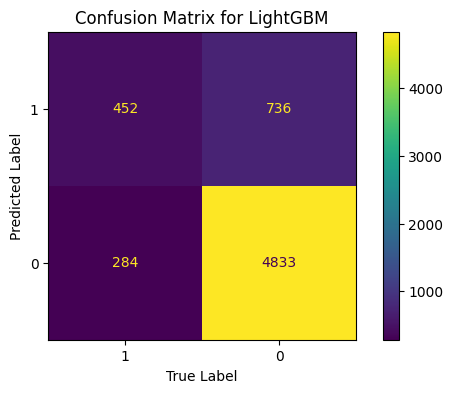

In [379]:
lgbm_fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(lgbm_predict,y_val,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)

ax.set_title("Confusion Matrix for LightGBM")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

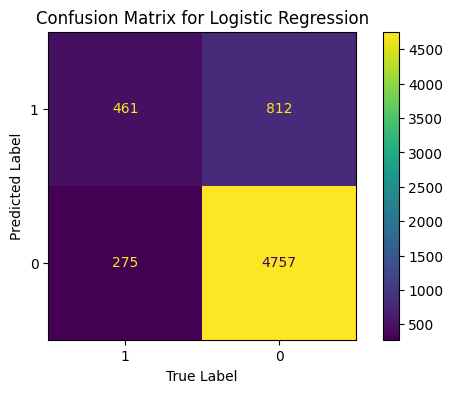

In [380]:
lg_fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(lg_predict,y_val,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)

ax.set_title("Confusion Matrix for Logistic Regression")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [381]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix_lgbm": wandb.Image(lgbm_fig_confusion_matrix),
        "confusion_matrix_lg": wandb.Image(lg_fig_confusion_matrix),
    }
)

08-05-2025 21:30:17 Uploading figures


### 1.5.2 Feature Importance

08-05-2025 21:30:18 Feature importance
08-05-2025 21:30:19 Saving LGBM feature importance figure


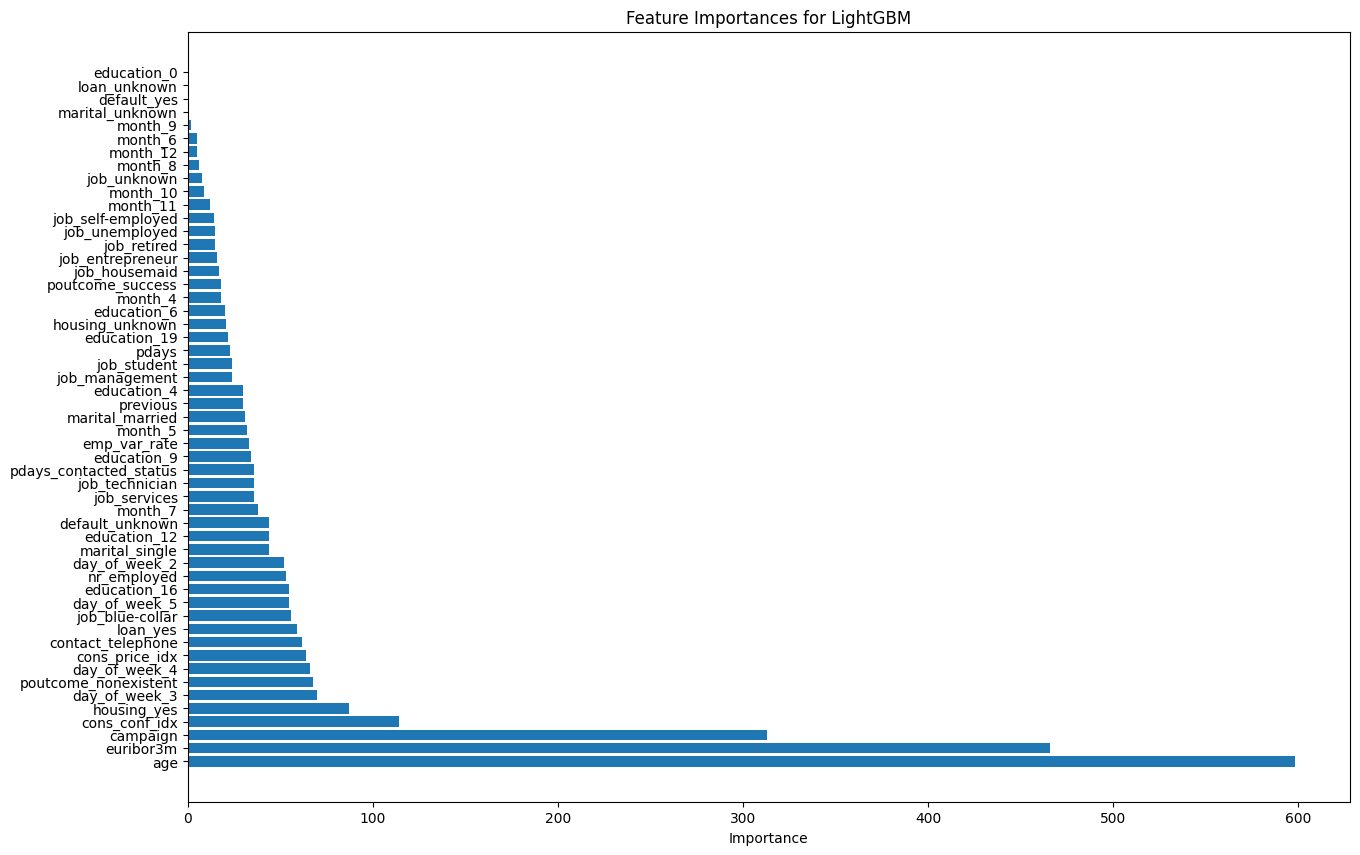

In [382]:
# Feature importance
logger.info("Feature importance")
# Get feature importances from the model
importances = lgbm.feature_importances_
# Get feature names from the pipeline
feature_names = df.columns.tolist()
# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(15, 10))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances for LightGBM')

#save figure
logger.info("Saving LGBM feature importance figure")
plt.savefig("LGBM_feature_importance.png")

08-05-2025 21:30:27 Feature importance
08-05-2025 21:30:28 Saving Logistic Regression feature importance figure


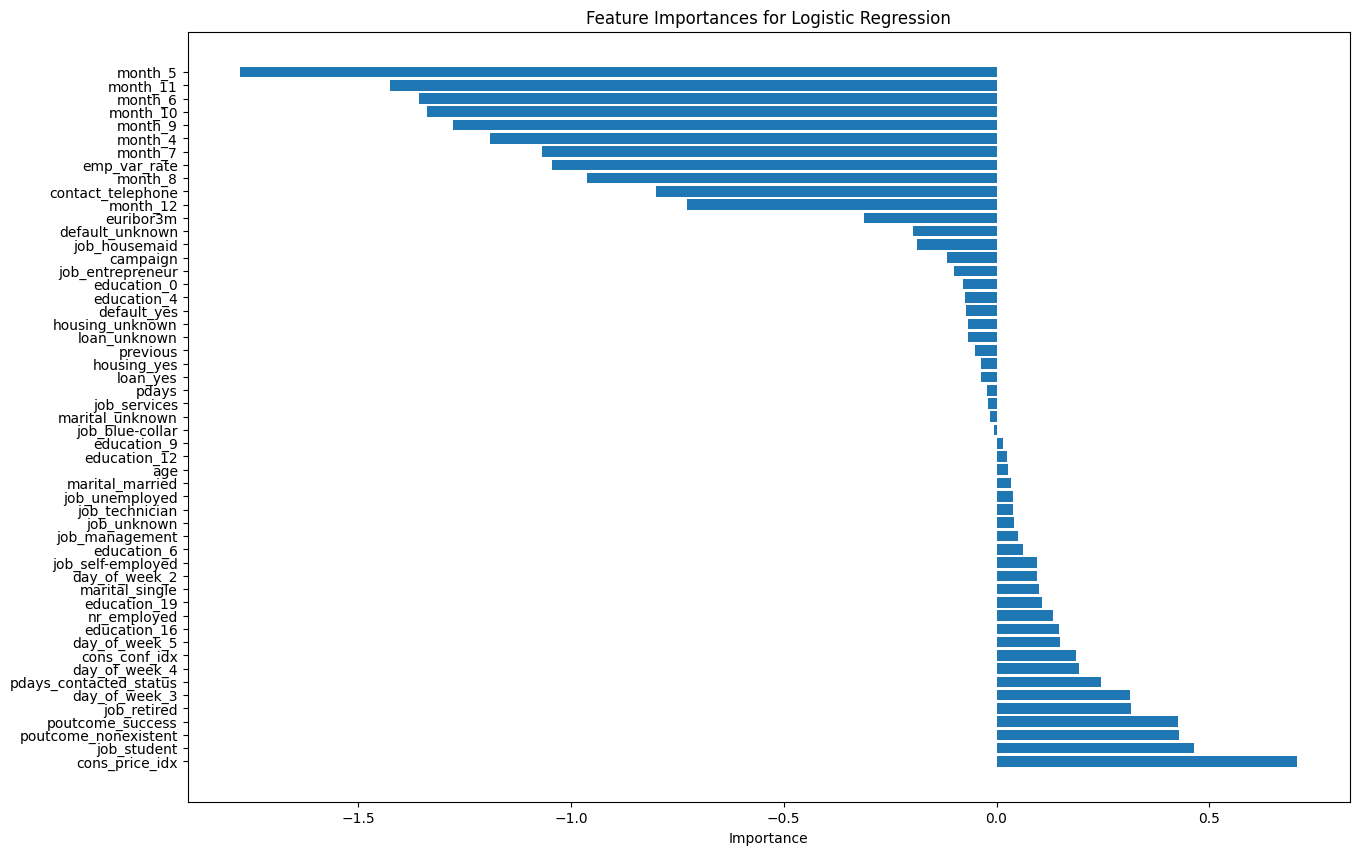

In [383]:
# Feature importance
logger.info("Feature importance")
# Get feature importances from the model
importances = lg.coef_[0]
# Get feature names from the pipeline
feature_names = df.columns.tolist()
# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(15, 10))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances for Logistic Regression')

#save figure
logger.info("Saving Logistic Regression feature importance figure")
plt.savefig("LG_feature_importance.png")

In [384]:
feature_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_0',
 'education_4',
 'education_6',
 'education_9',
 'education_12',
 'education_16',
 'education_19',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'contact_telephone',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'poutcome_nonexistent',
 'poutcome_success',
 'age',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

In [385]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(lg,
                              x_train_processed,
                              x_val_processed,
                              y_train,
                              y_val,
                              lg_predict,
                              lg.predict_proba(x_val_processed),
                              [0,1],
                              model_name='LR', feature_names=feature_names)

wandb: 
wandb: Plotting LR.


wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [386]:
wandb.sklearn.plot_classifier(lgbm,
                              x_train_processed,
                              x_val_processed,
                              y_train,
                              y_val,
                              lgbm_predict,
                              lgbm.predict_proba(x_val_processed),
                              [0,1],
                              model_name='LGBM', feature_names=feature_names)

wandb: 
wandb: Plotting LGBM.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [387]:
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_val, lg_predict, [0,1])
wandb.sklearn.plot_confusion_matrix(y_val, lgbm_predict, [0,1])

In [388]:
# Catch up the class proportions between train and validation
wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

In [389]:
# Plot the importance of columns
wandb.sklearn.plot_feature_importances(lgbm, feature_names=feature_names)
wandb.sklearn.plot_feature_importances(lg, feature_names=feature_names)

In [390]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
wandb.sklearn.plot_summary_metrics(lg,
                                x_train_processed,
                                y_train,
                                x_val_processed,
                                y_val)

wandb.sklearn.plot_summary_metrics(lgbm,
                                x_train_processed,
                                y_train,
                                x_val_processed,
                                y_val)

In [391]:
# ROC curve
lg_predict_proba = lg.predict_proba(x_val_processed)
lgbm_predict_proba = lgbm.predict_proba(x_val_processed)
wandb.sklearn.plot_roc(y_val, lg_predict_proba, [0,1])
wandb.sklearn.plot_roc(y_val, lgbm_predict_proba, [0,1])

In [392]:
x_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor3m', 'nr_employed', 'pdays_contacted_status'],
      dtype='object')

In [393]:
x_train.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
7234,25.0,admin,married,unknown,no,no,no,cellular,nov,thu,1.0,6.0,0.0,nonexistent,-3.4,92.649,-30.1,0.714,5017.5,0.0


In [394]:
y_train[0]

1

In [395]:
# Recreate person1 from the first row of the CSV
person1 = pd.DataFrame([[25.0, 'admin', 'married', 'unknown', 'no', 'no', 'no', 'cellular', 'nov', 'fri',
                         1.0, 6.0, 0.0, 'nonexistent', -3.4, 92.649, -30.1, 0.714, 5017.5, 0.0]],
                       columns=x_train.columns)

# Prediction (assuming pipe is already fitted)
pipe1 = Pipeline(steps=[('preprocessor', full_pipeline_preprocessing),
                       ('classifier', lgbm)])
pipe2 = Pipeline(steps=[('preprocessor', full_pipeline_preprocessing),
                        ('classifier', lg)])

pred = pipe1.predict(person1)
pred2 = pipe2.predict(person1)
print(pred[0], pred2[0])

1 1


In [396]:
person2 = pd.DataFrame([[55.0, 'unemployed', 'married', 'basic 9y', 'no', 'yes', 'no', 'cellular', 'oct', 'mon',
                         1.0, 6.0, 0.0, 'nonexistent', -3.4, 92.431, -26.9, 0.728, 5017.5, 0.0]], columns=x_train.columns)
print(pipe1.predict(person2), pipe2.predict(person2))

[1] [1]


In [397]:
# close the current run before to execute the next section
run.finish()

## 1.6 Hyperparameter Tuning

In [398]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [399]:
# global seed
#seed = 99

### Tuning for Logistic Regression

In [400]:
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice

In [ ]:
run = wandb.init(project="Bank-Marketing",job_type="hyperparameters tuning")

In [401]:
def objective(trial):
    # Define model with hyperparameters to optimize

    #tol = trial.suggest_float('tol', 1e-5, 1e-4, log=True)
    C = trial.suggest_float('C', 0.003, 0.01, log=True)
    class_weight = {
            0: trial.suggest_float(0, 1, 1.7, step=0.1),
            1: trial.suggest_float(1, 8.5, 9.5, step=0.1)
        }          
    model = LogisticRegression(
        #tol=tol, 
        C=C,
        class_weight=class_weight,
        max_iter= 1000
        )
    model.fit(x_train_processed, y_train)
    y_pred = model.predict(x_val_processed)
    y_pred_proba = model.predict_proba(x_val_processed)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    recall_s = recall_score(y_val, y_pred, zero_division=1)
    auc_pr = auc(recall, precision)  # compute AUC-PR
    f1_score = fbeta_score(y_val, y_pred, beta=1, zero_division=1)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    acc = accuracy_score(y_val, y_pred)

    return recall_s
    
    # Create and run Optuna study
logger.info("Starting Optuna study for Logistic Regression")
study = optuna.create_study(direction='maximize', sampler=TPESampler())
logger.info("Optimizing hyperparameters")
study.optimize(objective, n_trials=30)
    
    # Get best parameters
best_trial = study.best_trial
best_params = best_trial.params
best_value = best_trial.value
    
logger.info("Best parameters: {}".format(best_params))
logger.info("Best Recall score: {}".format(best_value))

08-05-2025 21:32:06 Starting Optuna study for Logistic Regression
[I 2025-05-08 21:32:06,169] A new study created in memory with name: no-name-a0e58f69-54db-4495-9554-222be66f3cbd
08-05-2025 21:32:06 Optimizing hyperparameters
[I 2025-05-08 21:32:08,211] Trial 0 finished with value: 0.6684782608695652 and parameters: {'C': 0.004413258204409404, 0: 1.0, 1: 8.5}. Best is trial 0 with value: 0.6684782608695652.
[I 2025-05-08 21:32:08,681] Trial 1 finished with value: 0.6385869565217391 and parameters: {'C': 0.005175050628070949, 0: 1.3, 1: 9.4}. Best is trial 0 with value: 0.6684782608695652.
[I 2025-05-08 21:32:09,073] Trial 2 finished with value: 0.6141304347826086 and parameters: {'C': 0.005641431683002108, 0: 1.4, 1: 8.9}. Best is trial 0 with value: 0.6684782608695652.
[I 2025-05-08 21:32:09,305] Trial 3 finished with value: 0.6100543478260869 and parameters: {'C': 0.003630181727430914, 0: 1.7, 1: 9.5}. Best is trial 0 with value: 0.6684782608695652.
[I 2025-05-08 21:32:09,491] Trial

In [402]:
m = LogisticRegression(**{ 'C': 0.00312260516665413, 'class_weight':{0: 1, 1:  9.5}, 'max_iter': 1000})
m.fit(x_train_processed, y_train)
mpredprob= m.predict_proba(x_val_processed)
threshold = 0.5
mpred = np.where(mpredprob[:, 1] > threshold, 1, 0)
print(classification_report(y_val,mpred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      5569
           1       0.29      0.68      0.41       736

    accuracy                           0.77      6305
   macro avg       0.62      0.73      0.63      6305
weighted avg       0.87      0.77      0.81      6305



In [403]:
roc_auc_score(y_val, mpredprob[:,1])

0.7921015110823112

In [404]:
recall_score(y_val, mpred, zero_division=1)

0.6820652173913043

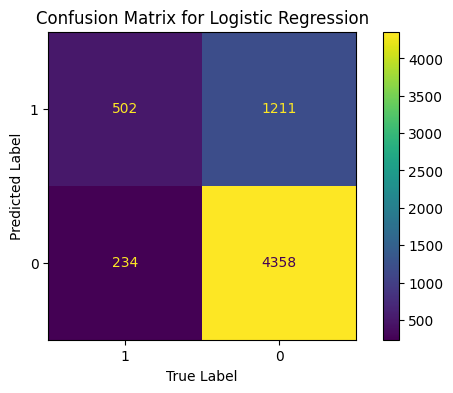

In [405]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(mpred,y_val,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)
                       
ax.set_title("Confusion Matrix for Logistic Regression")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

### Tuning for LightGBM

In [406]:
#!pip install optuna-integration[lightgbm]

In [408]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
import numpy as np
import lightgbm

def objective(trial):
    data, target = x_train_processed, y_train
    train_x, valid_x, train_y, valid_y = x_train_processed, x_val_processed, y_train, y_val

    # Giả sử y_train là mảng numpy hoặc pandas Series chứa nhãn 0/1
    weight_0 = trial.suggest_float("class_weight_0", 1, 1.5, step=0.1)
    weight_1 = trial.suggest_float("class_weight_1", 9.0, 9.5, step=0.1)

    sample_weight = np.where(y_train == 0, weight_0, weight_1)

    dtrain = lightgbm.Dataset(train_x, label=train_y, weight=sample_weight)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
    }
    gbm = lightgbm.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    r = recall_score(valid_y, pred_labels, zero_division=1)
    return r


if __name__ == "__main__":
    logger.info("Starting Optuna study for LightGBM")
    study = optuna.create_study(direction="maximize")
    logger.info("Optimizing hyperparameters")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    logger.info("Best Recall value: {}".format(trial.value))

    logger.info("Best Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))    

08-05-2025 21:48:58 Starting Optuna study for LightGBM
[I 2025-05-08 21:48:58,972] A new study created in memory with name: no-name-efa34ed1-b874-46aa-a8ef-ed83455971e1
08-05-2025 21:48:58 Optimizing hyperparameters
[I 2025-05-08 21:49:01,729] Trial 0 finished with value: 0.5801630434782609 and parameters: {'class_weight_0': 1.5, 'class_weight_1': 9.5, 'max_depth': 15, 'reg_alpha': 8.107986020415399e-07, 'reg_lambda': 2.528676581823165e-08, 'num_leaves': 146, 'feature_fraction': 0.8763503419146573, 'bagging_fraction': 0.8434462168544168, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 0 with value: 0.5801630434782609.
[I 2025-05-08 21:49:02,840] Trial 1 finished with value: 0.595108695652174 and parameters: {'class_weight_0': 1.5, 'class_weight_1': 9.0, 'max_depth': 10, 'reg_alpha': 1.5541977078335218e-06, 'reg_lambda': 0.00045951337303580346, 'num_leaves': 95, 'feature_fraction': 0.49054850260015437, 'bagging_fraction': 0.819736740765937, 'bagging_freq': 7, 'min_child_sampl

Number of finished trials: 100
Best trial:
    class_weight_0: 1.0
    class_weight_1: 9.2
    max_depth: 11
    reg_alpha: 4.590574379411927e-08
    reg_lambda: 5.364165602574015e-05
    num_leaves: 41
    feature_fraction: 0.41903934093830536
    bagging_fraction: 0.40251337723690406
    bagging_freq: 5
    min_child_samples: 82


In [ ]:
best_params= study.best_params
best_params['verbosity'] = -1
best_params['objective']= 'binary'
best_params['metric']='binary_logloss'

{'class_weight_0': 1.0,
 'class_weight_1': 9.2,
 'max_depth': 11,
 'reg_alpha': 4.590574379411927e-08,
 'reg_lambda': 5.364165602574015e-05,
 'num_leaves': 41,
 'feature_fraction': 0.41903934093830536,
 'bagging_fraction': 0.40251337723690406,
 'bagging_freq': 5,
 'min_child_samples': 82,
 'verbosity': -1,
 'objective': 'binary',
 'metric': 'binary_logloss'}

another try: {'class_weight_0': 1.0,
 'class_weight_1': 9.3,
 'reg_alpha': 0.0038399569534804346,
 'reg_lambda': 0.02050593804828291,
 'num_leaves': 162,
 'feature_fraction': 0.40033389181425705,
 'bagging_fraction': 0.4548821848901073,
 'bagging_freq': 5,
 'min_child_samples': 98,
 'verbosity': -1}

In [478]:
n = LGBMClassifier(**best_params, class_weight={0:1, 1:9.2})
n.fit(x_train_processed, y_train)
npred = n.predict(x_val_processed)
npredprob= n.predict_proba(x_val_processed)
#threshold = 0.5
#npred = np.where(npredprob[:, 1] > threshold, 1, 0)
print(classification_report(y_val,npred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      5569
           1       0.31      0.69      0.43       736

    accuracy                           0.79      6305
   macro avg       0.63      0.74      0.65      6305
weighted avg       0.88      0.79      0.82      6305



In [479]:
roc_auc_score(y_val, npredprob[:,1])

0.800694669443425

In [463]:
recall_score(y_val, npred, zero_division=1)

0.6875

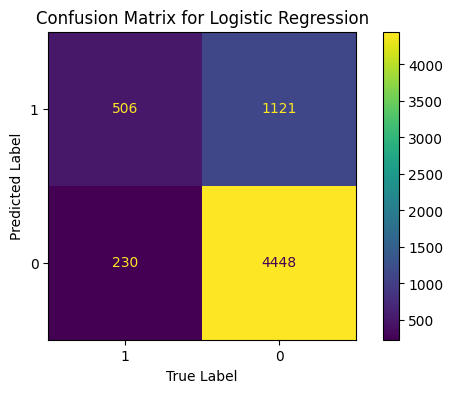

In [464]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(npred,y_val,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)
                       
ax.set_title("Confusion Matrix for Logistic Regression")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [1]:
run.finish()

NameError: name 'run' is not defined

## 1.7 Configure and train the best model

In [465]:
#Note that a new run is yet synced to last sweep run 
# Just to check
run = wandb.init(project="Bank-Marketing", job_type="Save best model" )

In [1]:
best_params={
 'max_depth': 11,
 'reg_alpha': 4.590574379411927e-08,
 'reg_lambda': 5.364165602574015e-05,
 'num_leaves': 41,
 'feature_fraction': 0.41903934093830536,
 'bagging_fraction': 0.40251337723690406,
 'bagging_freq': 5,
 'min_child_samples': 82,
 'verbosity': -1,
 'objective': 'binary',
 'metric': 'binary_logloss'}

In [466]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier", LGBMClassifier(**best_params, class_weight={0:1, 1:9.3}))
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
#pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)
predict_proba = pipe.predict_proba(x_val)[:,1]

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)
roc_auc = roc_auc_score(y_val, predict_proba)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))
logger.info("ROC_AUC: {}".format(roc_auc))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
run.summary['ROC_AUC']= roc_auc

08-05-2025 22:26:04 Training
08-05-2025 22:26:08 Infering
08-05-2025 22:26:09 Evaluation metrics
08-05-2025 22:26:09 Accuracy: 0.780650277557494
08-05-2025 22:26:09 Precision: 0.3042952208106473
08-05-2025 22:26:09 Recall: 0.6834239130434783
08-05-2025 22:26:09 F1: 0.4210966931770615
08-05-2025 22:26:09 ROC_AUC: 0.7999632329978842


In [467]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_0',
 'education_4',
 'education_6',
 'education_9',
 'education_12',
 'education_16',
 'education_19',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'contact_telephone',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'poutcome_nonexistent',
 'poutcome_success']

In [468]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['age',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

In [469]:
# merge all column names together
all_names = cat_names + num_names
all_names

['job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_0',
 'education_4',
 'education_6',
 'education_9',
 'education_12',
 'education_16',
 'education_19',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'contact_telephone',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'poutcome_nonexistent',
 'poutcome_success',
 'age',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'pdays_contacted_status']

In [470]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

wandb: 
wandb: Plotting BestModel.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


## 1.8 Export the best model

In [471]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [472]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

08-05-2025 22:26:23 Dumping the artifacts to disk


['target_encoder']

In [473]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a LightGBM model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

08-05-2025 22:26:23 Logging model artifact


In [474]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

08-05-2025 22:26:23 Logging target enconder artifact


In [475]:
run.finish()

Acc,0.78065
F1,0.4211
Precision,0.3043
ROC_AUC,0.79996
Recall,0.68342
